## Lede Algorithms 2018 Week 2 class 2 - Logistic Regression

This notebook builds up to logistic regression, that is, fitting a model that predicts the output where there are only two choices. But before that, we're going to do many comparisons and visualizations to talk about the underlying ideas that regression is getting at -- especially the idea of "controlling for" another factor. 

Throughout we'll be using data on citations for speeding from Massechusets from 2001. This data was originally analyzed by the Boston Globe for their series [Speed Trap: Who gets a ticket, who gets a break?](http://archive.boston.com/globe/metro/packages/tickets/). You can read about their analysis in this [methodology document](http://archive.boston.com/globe/metro/packages/tickets/study.pdf), and get the original data [here](http://archive.boston.com/globe/metro/packages/tickets/warnings.zip). I've added a header row the CSV file, but otherwise `tickets-warnings.csv` in this directory is identical.

Why such old data? Well, for one thing it's a classic example of multi-variable regression in journalism. But also, for a brief period of April and May 2001, the state government entered both tickets and warnings from the paper citations. In Massechusets at that time, both were written on the same form, with only a checkbox indicating which it was. A ticket means a fine and a raises your insurance premium. A warning means nothing. Having data on both means we can ask who gets a ticket vs. a warning for the same circumstances.

We have a ton of data about each stop, including the speed, age, race, gender, and home zip code of the driver. The journalistic question is, are some groups more likely to get tickets, and not warnings, than others?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tw_raw = pd.read_csv('tickets-warnings.csv')
tw_raw

,TYPE,CITATION,DATE,DOW,AGENCY,AGENCY2,AGENCY3,LOCAL,OFFICER,LICSTATE,...,V_YEAR,V_AGE,V_AGEGRP,COLOR,HOMESTATE,HOMETOWN,INTOWN,INSTATE,INTOWN2,INSTATE2
0,T,K0001506,20010411.0,Wednesday,State Police Troop A-4,State Police,S,N,8.247791e+15,MA,...,0.0,NaN,U,NaN,MA,Tewksbury,N,Y,0.0,1.0
1,T,K0001507,20010417.0,Tuesday,State Police Troop A-4,State Police,S,N,8.247791e+15,MA,...,1988.0,13.0,older,WHITE,MA,Boston,N,Y,0.0,1.0
2,T,K0001509,20010420.0,Friday,State Police Troop A-4,State Police,S,N,8.247791e+15,NH,...,0.0,NaN,U,NaN,NH,NaN,N,N,0.0,0.0
3,T,K0001510,20010420.0,Friday,State Police Troop A-4,State Police,S,N,8.247791e+15,NH,...,0.0,NaN,U,NaN,NH,NaN,N,N,0.0,0.0
4,T,K0001511,20010427.0,Friday,State Police Troop A-4,State Police,S,N,8.247791e+15,MA,...,2000.0,1.0,new,BLACK,MA,Haverhill,N,Y,0.0,1.0
5,T,K0001513,20010502.0,Wednesday,State Police Troop A-4,State Police,S,N,8.247791e+15,MA,...,0.0,NaN,U,NaN,MA,Topsfield,N,Y,0.0,1.0
6,W,K0001514,20010506.0,Sunday,State Police Troop A-1,State Police,S,N,8.247791e+15,NH,...,0.0,NaN,U,NaN,NH,NaN,N,N,0.0,0.0
7,W,K0001515,20010506.0,Sunday,State Police Troop A-1,State Police,S,N,8.247791e+15,NH,...,0.0,NaN,U,NaN,NH,NaN,N,N,0.0,0.0
8,W,K0001516,20010506.0,Sunday,State Police Troop A-1,State Police,S,N,8.247791e+15,MA,...,0.0,NaN,U,NaN,MA,Lawrence,Y,Y,1.0,1.0
9,W,K0001517,20010506.0,Sunday,State Police Troop A-1,State Police,S,N,8.247791e+15,MA,...,1992.0,9.0,older,BLUE,MA,Waltham,N,Y,0.0,1.0


For a complete description of all 57 fields, see the [methodology](http://archive.boston.com/globe/metro/packages/tickets/study.pdf). For our purposes, we are only intersted in the citations for speeding, and most interested in the fields `TYPE` (ticket or warning), `MINORITY`, `SEX`, `AGE`, and `MPHOVER`.

In [3]:
tw = tw_raw[tw_raw['DESCRIPT']=='SPEEDING'].reset_index(drop=True)
tw = tw[['DATE', 'TYPE', 'AGENCY3', 'SEX','MINORITY','AGE','MPH','MPHOVER','INTOWN']]
tw.head()

,DATE,TYPE,AGENCY3,SEX,MINORITY,AGE,MPH,MPHOVER,INTOWN
0,20010411.0,T,S,M,W,21.0,80.0,15.0,N
1,20010427.0,T,S,M,W,24.0,85.0,20.0,N
2,20010502.0,T,S,M,W,37.0,80.0,30.0,N
3,20010506.0,W,S,M,W,30.0,80.0,15.0,N
4,20010506.0,W,S,F,M,22.0,75.0,10.0,N


Let's start with the total number of minority vs. white drivers

In [4]:
tw.groupby('MINORITY').count()

,DATE,TYPE,AGENCY3,SEX,AGE,MPH,MPHOVER,INTOWN
MINORITY,,,,,,,,
M,12836,12836,12836,12836,12833,12836,12609,12836
U,1633,1633,1633,1633,1632,1633,1592,1633
W,79275,79275,79275,79275,79262,79275,78071,79275


What fraction of citations were given to minorities? 

In [5]:
12836/(12836+79275)

0.13935360597539925

Is 13% a lot or a little? We could compare to the minority population of the towns where these stops happened, but what about people driving through? And there's no guarantee drivers in both groups have the same distribution of speeds. 

This is often called the "denominator problem." To deal with this issue, we're going to compare the probability of getting a warning, as opposed to a ticket, between the groups.

First, let's clean up the data a little but dropping the (relatively small) number of records where the minority status is unknown.

In [6]:
# drop the unknown race entries
tw = tw[tw['MINORITY'] != 'U'].reset_index(drop=True)  # renumber the rows, and don't create a new column

In [7]:
sz = tw.groupby(['MINORITY','TYPE']).size()
sz

MINORITY  TYPE
M         T        7731
          W        5105
W         T       40126
          W       39149
dtype: int64

In [8]:
pd.crosstab(tw.MINORITY,tw.TYPE)

TYPE,T,W
MINORITY,,
M,7731,5105
W,40126,39149


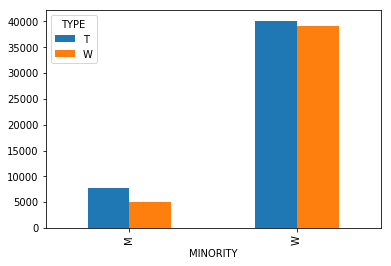

In [9]:
pd.crosstab(tw.MINORITY,tw.TYPE).plot(kind='bar')

In [10]:
# percent of minority citations which were tickets
sz['M']['T'] / sum(sz['M'])

0.60229043315674669

In [11]:
# percent of non-minority citations which were tickets
sz['W']['T'] / sum(sz['W'])

0.50616209397666356

We can make a nice little chart of this...

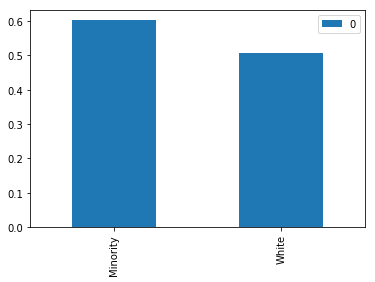

In [12]:
pd.DataFrame([sz['M']['T'] / sum(sz['M']), sz['W']['T'] / sum(sz['W'])], index=['Minority','White']).plot(kind='bar')

But how do we know that the drivers in these two groups are really the same? We imagine that there are more tickets given to faster drivers (`MPHOVER` is how much over the speed limit the driver was). Legend also has it that traffic cops are harsher to drivers from out of town (`INTOWN` records where the driver was from.)

To get a sense of this, let's compare histograms of the two groups.

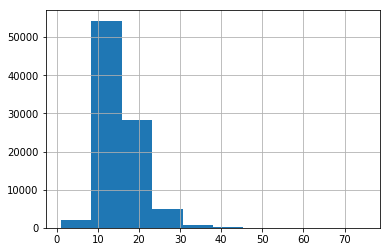

In [13]:
tw['MPHOVER'].hist()

We've used `MPHOVER` because speed over the limit is probably more interesting than how fast in absolute terms. But checking raw `MPH`, we see a problem with the data: some of the entries don't record the speed! Fortunately, not very many. 

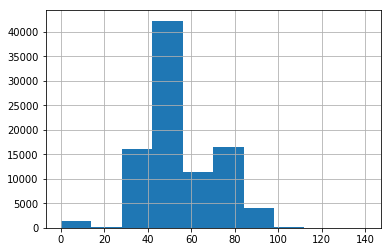

In [14]:
tw['MPH'].hist()

To see if the distributions are different between white and minorities, let's try plotting them on the same chart.

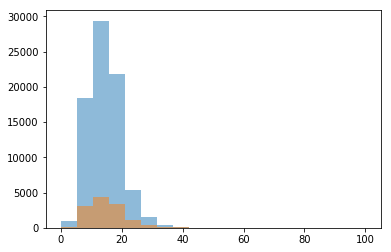

In [15]:
w_over = tw[tw['MINORITY']=='W']['MPHOVER'].dropna()  # need dropna because some rows don't record speed
m_over = tw[tw['MINORITY']=='M']['MPHOVER'].dropna()

bins = np.linspace(0, 100, 20)
plt.hist(w_over,bins,alpha=0.5)
plt.hist(m_over,bins,alpha=0.5)
plt.show()

Still very hard to see, because the scaling is so different. Let's normalize the histograms to display percentages instead of counts.

(array([  2.20001586e-03,   4.55674518e-02,   6.66936315e-02,
          5.09318741e-02,   1.58973749e-02,   5.50003965e-03,
          2.03426124e-03,   6.78087081e-04,   3.01372036e-04,
          9.04116108e-05,   4.52058054e-05,   3.01372036e-05,
          0.00000000e+00,   1.50686018e-05,   1.50686018e-05,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00]),
 array([   0.        ,    5.26315789,   10.52631579,   15.78947368,
          21.05263158,   26.31578947,   31.57894737,   36.84210526,
          42.10526316,   47.36842105,   52.63157895,   57.89473684,
          63.15789474,   68.42105263,   73.68421053,   78.94736842,
          84.21052632,   89.47368421,   94.73684211,  100.        ]),
 <a list of 19 Patch objects>)

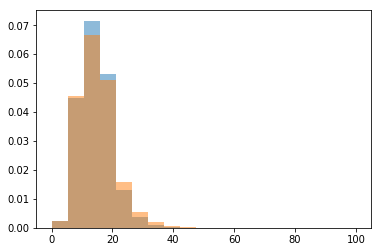

In [16]:
plt.hist(w_over,bins,alpha=0.5,density=True)
plt.hist(m_over,bins,alpha=0.5,density=True)


Hmm, they look pretty close. The minorities plot has a slightly fatter tail, so that's some evidence that they're driving faster, but it doesn't seem to be a huge difference. Let's take a look at the averages, just to get another sense.

In [17]:
w_over.mean()

15.066798170895723

In [18]:
m_over.mean()

15.575303354746609

So, about half a mile an hour on average difference. Still, this could make the difference if, for example, it pushes a lot of drivers greater than some threshold like 20 mph over the limit. We're going to need to untangle the effects here.

In fact there could be all sorts of things going on here. Age and sex could be factors. In town or out of town drivers could matter. The `AGENCY` column records whether the stop was made by Massechusets state police, Boston police, or all other police departments, and that could matter both in terms of how the different agencies operate and in terms of who is driving within their jurisdiction. 

For our purposes, bias means that minorities get a ticket more often than white people *when everything else is equal.* Is everything else equal? Let's plot a pile of histograms to take a look.

In [19]:
def comparehist(colname):
    w = tw[tw['MINORITY']=='W'][colname].dropna()
    m = tw[tw['MINORITY']=='M'][colname].dropna()
    
    if tw[colname].dtype == np.float64:
        # it's numeric, plot a histogram
        bins = np.linspace(0, 100, 20)
        plt.hist(w,bins,alpha=0.5,density=True)
        plt.hist(m,bins,alpha=0.5,density=True)
    else:
        # if not numerican, assume it's categorical and plot a bar chart of value counts normalized to percentages
        wc = w.value_counts()
        wc /= sum(wc)
        plt.bar(wc.index, wc, alpha=0.5)
        mc = m.value_counts()
        mc /= sum(mc)
        plt.bar(mc.index, mc, alpha=0.5)
        
    plt.title(colname)
    plt.show()


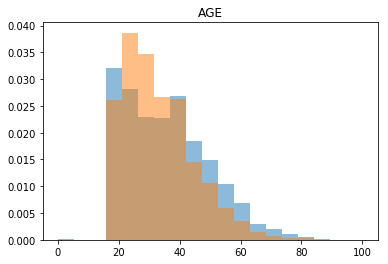

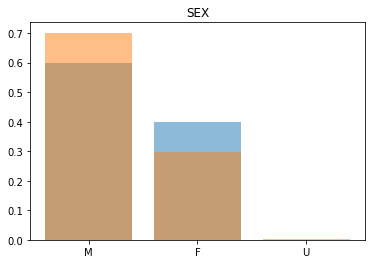

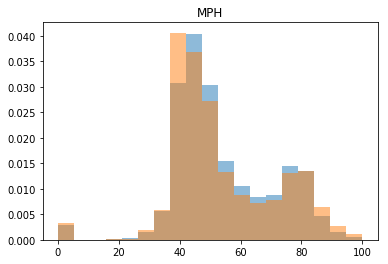

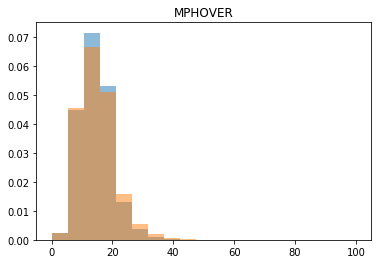

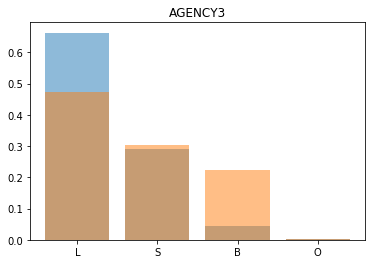

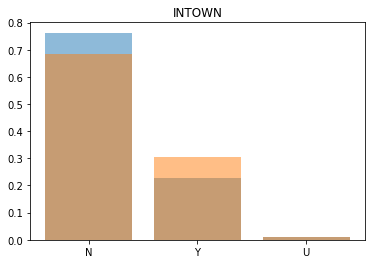

In [20]:
comparehist('AGE')
comparehist('SEX')
comparehist('MPH')
comparehist('MPHOVER')
comparehist('AGENCY3')
comparehist('INTOWN')


What can we say here? The minority drivers in this sample have more people in their 20s, skew male, are going slightly faster when they're pulled over, are less likely to be stopped by local police and more likely to be stopped by Boston police, and tend to be out of town more often. Any or all of these effects could account for the difference in ticketing rates. There could even be interactions here: suppose Boston police are harder on people who drive more than 10 mph over the limit. These minority drivers are both more commonly in Boston and going faster on average.

### Enter logistic regression
We're going to use regression to try to analyze the relationships between the variables and whether someone gets a ticket. But everything is going to be a little bit different than last class because the variable we are going to try to predict is binary: it's a yes/no, did they get a ticket or not, instead of a numeric value.

In [21]:
from sklearn.linear_model import LinearRegression,LogisticRegression



To set up the regression, let's look at a graph of MPH over the limit on the x axis, vs. whether the driver got a ticket on the y axis, represented as 0 or 1. 

In [22]:
# add a column that is 1 if they got a ticket (not a warning)
tw['BUSTED'] = tw['TYPE'].replace({'W':0, 'T':1})

# Remove rows where MPH is unknown
tw = tw[~tw['MPHOVER'].isnull()].reset_index()

In [23]:
# sort by MPHOVER (makes the plotting below simpler)
tw = tw.sort_values(by='MPHOVER')

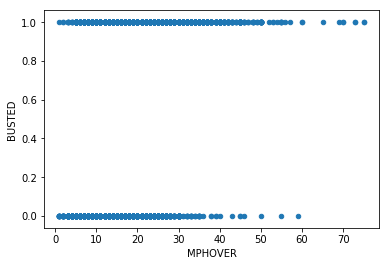

In [24]:
x = tw[['MPHOVER']].values
y = tw[['BUSTED']].values
tw.plot(kind='scatter',x='MPHOVER',y='BUSTED')

This has a general "upward slope." Let's use linear regression to try to fit a trend line to it.

/Users/jonathanstray/anaconda/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


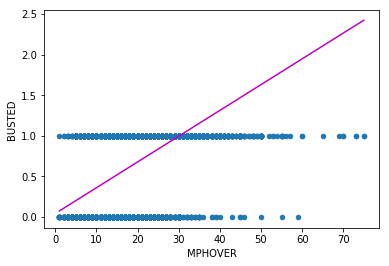

In [25]:
lm = LinearRegression()
lm.fit(x,y)
tw.plot(kind='scatter',x='MPHOVER',y='BUSTED')
plt.plot(x,lm.predict(x),'-',color='m')

This is a little strange, because we're trying to predict binary outcome with a straight line. If you like, you can imagine that whenever this line is 0.5 or greater, we guess "got a ticket." But really we should use a model that always predicts a value between 0 and 1 -- a probability. 

To do this we fit a "logistic" function, not a line. This is a function which is an S-shape, and turns any number into a number from 0 to 1

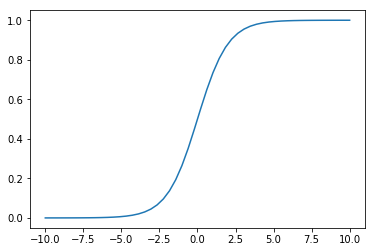

In [26]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

linear_range = np.linspace(-10,10)
plt.plot(linear_range, logistic(linear_range))

The exact center of this function, at x=0, has a probability of 0.5, meaning "I'm indifferent guessing between these two options."

In [27]:
logistic(0)

0.5

Let's apply logistic regression and plot the answer. To interpret the output, we take our normal `y=mx+b` line but run it through the logistic function.

/Users/jonathanstray/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


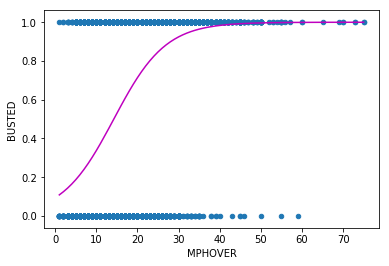

In [28]:
# Run the logistic regression on our data
lm = LogisticRegression()
lm.fit(x,y)

# plot original data
tw.plot(kind='scatter',x='MPHOVER',y='BUSTED')

# Now plot the prediction of the fitted model
m = lm.coef_[0]
b = lm.intercept_
line_y = m*x+b
prediction = logistic(line_y) 
plt.plot(x, prediction, '-', color='m')

We can do the same thing with the `predict_proba` function (though it returns two columns: one is the probability of  FALSE and the other is the probability of TRUE, so we plot only the second column)

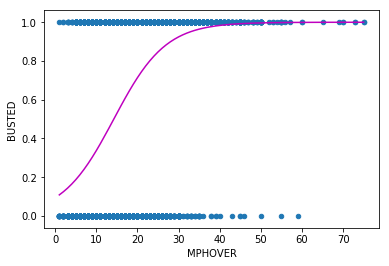

In [29]:
tw.plot(kind='scatter',x='MPHOVER',y='BUSTED')
plt.plot(x, lm.predict_proba(x)[:,1], '-', color='m')

### Odds ratios

Here's a useful fact: the "slope" coefficients of a logistic regression means something when the indepenent variable is binary: it's the *odds ratio*.

Suppose we have a dinner party where each person eats chicken or fish. But oh no! Some people got sick afterwards. To see if it was related to what they ate, we can calculate the odds ratio.

In [30]:
# the fish column is 0 if they ate chicken, 1 if fish
dinner = pd.DataFrame([[0,1],[0,0],[0,0],[1,0],[1,1],[1,1]], columns=['fish','sick'])
dinner

,fish,sick
0,0,1
1,0,0
2,0,0
3,1,0
4,1,1
5,1,1


The "odds" of getting sick if you ate chicken are just the number of people who ate chicken and got sick, divided by the number of people who ate chicken and did not get sick.

In [31]:
# useful little function
ct = pd.crosstab(dinner.fish, dinner.sick)
ct

sick,0,1
fish,,
0,2,1
1,1,2


In [32]:
# odds of getting sick if you ate chicken
chicken_odds = ct[0][1] / ct[0][0]
chicken_odds

0.5

In [33]:
# odds of getting sick if you ate fish
fish_odds = ct[1][1] / ct[1][0]
fish_odds

2.0

Then "odds ratio" is, yup, the ratio of these sets of odds. It measures how your odds of getting sick *changed* if you ate the fish. 

In [34]:
fish_odds / chicken_odds

4.0

Now let's do a logistic regression to predict who gets sick

In [35]:
x=dinner[['fish']].values
y=dinner[['sick']].values
lm = LogisticRegression(C=1e5) # this C thing... we just need some large value here, it's a long story
lm.fit(x,y)

/Users/jonathanstray/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [36]:
# To get the odds ratio, we use the following formula:
np.exp(lm.coef_)



array([[ 3.99979205]])

### Controlling for other variables

We can feed as many independent variables as we like into linear regression. With two variables, instead of fitting a plane to the data we are fitting a curved surface. 

But here's the cool thing: just like linear regression each coefficient tells us how much that independent variable effects the probability of getting a ticket *if all other variables stay the same.*



In [37]:
# Code these variables a binary
tw.SEX = tw.SEX.replace({'M':0,'F':1, 'U':0})
tw.MINORITY = tw.MINORITY.replace({'W':0,'M':1})
tw.INTOWN = tw.INTOWN.replace({'N':0,'Y':1, 'U':0})

# remove unknown ages
tw = tw[~tw.AGE.isnull()].reset_index()

In [39]:
# Do a logistic regression on many fields at the same time
fields = ['MPHOVER','MINORITY','SEX', 'AGE', 'INTOWN']
x = tw[fields].values
y = tw[['BUSTED']].values
lm = LogisticRegression() 
lm.fit(x,y)
       
# print out the odds ratios for each variable
results = pd.DataFrame(np.exp(lm.coef_), columns=fields)
results

/Users/jonathanstray/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,MPHOVER,MINORITY,SEX,AGE,INTOWN
0,1.169127,1.461251,0.72036,0.985098,0.508197
